In [40]:
import numpy as np
import matplotlib.pyplot as plt
import gsd.hoomd
import hoomd
from monk import pair
import tqdm

In [41]:
file = "/media/ian/Data2/monk/2d-osc-shear/workspace/7ec2f6aca035e69077eab24383a21cb6/init.gsd"

In [42]:
traj = gsd.hoomd.open(file, 'rb')

In [43]:
snap = traj[0]

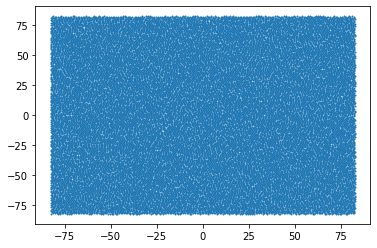

In [44]:
plt.scatter(snap.particles.position[:,0], snap.particles.position[:,1], s=1)

In [66]:
sim = hoomd.Simulation(hoomd.device.GPU())

sim.create_state_from_gsd(filename=file)

#setup fire 
nlist = hoomd.md.nlist.Cell(0.3)
force = pair.KA_LJ(nlist)
fire = hoomd.md.minimize.FIRE(5e-2, 1e-4, 1.0, 1e-10)
fire.forces.append(force)
filter = hoomd.filter.Tags(list(np.arange(snap.particles.N)[1:]))
# filter = hoomd.filter.All()
# nve = hoomd.md.methods.NVE(filter=filter)
nve = hoomd.md.methods.DisplacementCapped(filter, 0.01)
fire.methods.append(nve)

sim.operations.integrator = fire

sim.run(0)

In [67]:
fire.reset()
pbar = tqdm.tqdm()
while not fire.converged:
    f = force.forces
    max_f = np.max(np.linalg.norm(f, axis=1))
    pbar.set_description(f"max_f: {max_f}")
    pbar.update(1)
    sim.run(1000)

max_f: 8678299.778264318: : 1it [01:05, 65.16s/it]
max_f: 0.01738844948285482: : 610it [00:59, 10.29it/s]  

KeyboardInterrupt: 

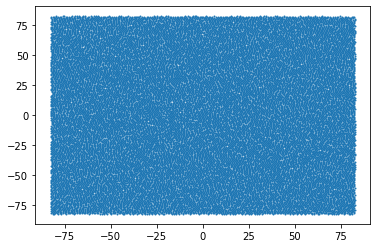

In [68]:
pos = sim.state.get_snapshot().particles.position

plt.scatter(pos[:,0], pos[:,1], s=1)

In [69]:
orig_pos = snap.particles.position

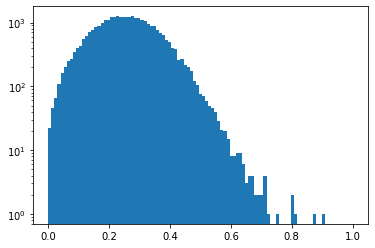

max_f: 0.01738844948285482: : 611it [01:17, 10.29it/s]

In [70]:
plt.hist(np.linalg.norm(pos - orig_pos, axis=1), bins=np.linspace(0, 1, 100))
plt.yscale('log')